# Maximum Entropy Matching Distribution Function

This notebook can construct the distribution function which maximizes the kinetic entropy subject to the constraints of matching the energy density $\epsilon$ and the total isotropic pressure $P \equiv p + \Pi$.

The entropy density current is expressed

$$s^{\mu}(x) = - \sum_h \frac{g_h}{(2\pi)^3}\int \frac{d^3p}{p_0} p^{\mu} \phi[f_h],$$

where $h$ runs over all hadronic species, $g_h$ is the degeneracy of species $h$, and $f_h(x;p)$ is the distribution function of particles of species $h$.

The function $\phi[f_h]$ defined by

$$ \phi[f] \equiv f \ln (f) - \frac{1 + \theta f}{\theta} \ln(1 + \theta f)$$

defines the quantum statistical nature of the particles, with $\theta = 1$, $0$ or $-1$ for bosons, Maxwell-Boltzmann particles, and fermions respectively.

In [1]:
%load_ext Cython
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dill
import pandas as pd
sns.set()
sns.set_context('talk')

## The cell below constructs the grid of energy density and pressure
It takes a while to run. Unless we need to change the particle/grid options, we can just load the grid from disk.
If you want to change the grid limits, discretization, or change the Hadron Resonances Gas, it needs to be rerun.
To do this, set `recalculate_grids = True`.

The particle information is loaded from the PDG particle data table using functions defined here: https://github.com/Duke-QCD/frzout.

In [2]:
%%cython 
import numpy as np
cimport numpy as np
from scipy import integrate
import time
from libc.math cimport exp
from libc.math cimport sqrt

DTYPE = np.float
ctypedef np.float_t DTYPE_t

### physical constants
cpdef float hbar = 0.197
cpdef float hbar3 = hbar*hbar*hbar

from species import species_dict, _normalize_species, urqmd
species = _normalize_species(species=urqmd)
for pid in species:
    pid[1]['sign'] = 1. if pid[1]['boson'] else -1.
n_species = len(species)

############################
########USER OPTIONS########
#particles included in thermodynamic quantities
chosen_particles = species_dict.keys()

#Grid parameters
cdef int npts_beta = 200 #size of grid in beta 
cdef int npts_rho = 200 #size of grid in rho 

cdef float T_eff_max = 0.20 #GeV
cdef float T_eff_min = 0.05 #GeV

#|lambda| <= |beta|
#so define rho by lambda = rho * beta, with rho in [-1, 1]
cdef float rho_min = -0.9
cdef float rho_max = 0.9
############################
########USER OPTIONS########

cdef float beta_min = 1. / T_eff_max #GeV^-1
cdef float beta_max = 1. / T_eff_min #GeV^-1
beta_grid = np.linspace(beta_min, beta_max, npts_beta)

rho_grid = np.linspace(rho_min, rho_max, npts_rho)

# The Max. Entropy Distribution Function
cpdef float f_dist(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, lambdapi, arg
    E2 = E*E
    m2 = m*m
    lambdapi = rho*beta
    arg = E * ( beta + lambdapi*(1. - m2/E2) )
    return 1./(exp(arg) - sign)

# The Equil. Distribution Function
cpdef float f_eq(float E, float beta_eq, float sign):
    cdef float arg
    arg = beta_eq * E
    return 1./(exp(arg) - sign)

# The Linear CE RTA distribution
cpdef float f_CE_lin(float E, float beta_eq, float bulk_Pi, 
                     float beta_Pi, float F, float m, float sign):
    cdef float E2, m2, f0, f_fbar, a, b, df, f
    E2 = E*E
    m2 = m*m
    f0 = f_eq(E, beta_eq, sign)
    f_fbar = f0 * (1. + sign*f0)
    a = beta_eq * beta_eq * F * E
    b = beta_eq * (E2 - m2) / 3. / E
    df = f_fbar * bulk_Pi * (a + b) / beta_Pi
    f = f0 + df
    #print(str(f0) + " + " + str(df))
    return f
    
cpdef float eps_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E2 * sqrt(E2 - m2) * f_dist(E, beta, rho, m, sign)
    
cpdef float eps(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(eps_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

cpdef float P_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3 / 3.
    return num_factor * (E2 - m2)**(1.5) * f_dist(E, beta, rho, m, sign)
    
cpdef float P(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(P_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

#check this formula for density
cpdef float n_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E * sqrt(E2 - m2) * f_dist(E, beta, rho, m, sign)

cpdef float n(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(n_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

#check this formula for density for linear CE
cpdef float n_integrand_CE(float E, float beta_eq, float bulk_Pi, 
                            float beta_Pi, float F, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / hbar3
    return num_factor * E * sqrt(E2 - m2) * f_CE_lin(E, beta_eq, bulk_Pi, 
                                                     beta_Pi, F, m, sign)

cpdef float n_CE(float beta_eq, float bulk_Pi, float beta_Pi, float F, 
                 float m, float sign):
    cdef float val, err
    val, err = integrate.quad(n_integrand_CE, m, np.inf, args=(beta_eq, bulk_Pi, 
                            beta_Pi, F, m, sign))
    return val

#Calculate the grid
recalculate_grids = False

cdef np.ndarray eps_grid = np.zeros((npts_beta, npts_rho), dtype=DTYPE)
cdef np.ndarray P_grid = np.zeros((npts_beta, npts_rho), dtype=DTYPE)
cdef np.ndarray eq_eps_grid = np.zeros(npts_beta, dtype=DTYPE)
cdef np.ndarray eq_p_grid = np.zeros(npts_beta, dtype=DTYPE)

cdef float m, sign, degen, has_anti
cdef float beta, rho
cdef int ibeta, irho

t1 = time.time()
if recalculate_grids:
                
    for k in range(n_species): #sum over species
        particle = species[k]
        pid = particle[0]
        particle_dict = particle[1]
        m = particle_dict['mass']
        sign = particle_dict['sign']
        degen = particle_dict['degen']
        prefac = degen
        
        for ibeta, beta in enumerate(beta_grid):
            eq_eps_grid[ibeta] += prefac * eps(beta, 0.0, m, sign) 
            eq_p_grid[ibeta] += prefac * P(beta, 0.0, m, sign)
            #eq_beta_Pi_grid[ibeta] += prefac * beta_Pi(beta, m, sign)
            
            for irho, rho in enumerate(rho_grid):
                eps_grid[ibeta, irho] += prefac * eps(beta, rho, m, sign)
                P_grid[ibeta, irho]   += prefac * P(beta, rho, m, sign)
                
        
    np.savetxt("grids/eps.dat", eps_grid)
    np.savetxt("grids/P.dat", P_grid)
    
    np.savetxt("grids/eq_eps.dat", eq_eps_grid)
    np.savetxt("grids/eq_p.dat", eq_p_grid)
t2 = time.time()

In [3]:
print("Time elapsed : " + str(t2-t1) + " sec")

Time elapsed : 9.5367431640625e-07 sec


### Load the pre-calculated grids from disk

In [4]:
#load the pre-calculated grid
eps_grid = np.loadtxt("grids/eps.dat")
P_grid = np.loadtxt("grids/P.dat")

eq_eps_grid = np.loadtxt("grids/eq_eps.dat")
eq_p_grid = np.loadtxt("grids/eq_p.dat")

In [5]:
#load the tables from iS3D for Linear Chapman Enskog
beta_Pi_df = pd.read_csv('grids/iS3D_tables/urqmd/betabulk.dat', sep='  ')
F_df = pd.read_csv('grids/iS3D_tables/urqmd/F.dat', sep='  ')

/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#Units in tables according to M. McNelis
beta_Pi_df['beta_Pi[GeV/fm^3]'] = beta_Pi_df['betabulk_over_T4[GeV^-1fm^-3]'] * (beta_Pi_df['T[GeV]']**4. )
beta_Pi_df['beta[GeV^-1]'] = 1. / beta_Pi_df['T[GeV]']

F_df['F[GeV]'] = F_df['F_over_T'] * F_df['T[GeV]']
F_df['beta[GeV^-1]'] = 1. / F_df['T[GeV]']

In [7]:
beta_Pi_df

,T[GeV],muB[GeV],betabulk_over_T4[GeV^-1fm^-3],beta_Pi[GeV/fm^3],beta[GeV^-1]
0,0.100,0.0,9.173387,0.000917,10.000000
1,0.101,0.0,9.458146,0.000984,9.900990
2,0.102,0.0,9.747904,0.001055,9.803922
3,0.103,0.0,10.042641,0.001130,9.708738
4,0.104,0.0,10.342339,0.001210,9.615385
...,...,...,...,...,...
96,0.196,0.0,67.448347,0.099540,5.102041
97,0.197,0.0,68.526827,0.103211,5.076142
98,0.198,0.0,69.617382,0.106999,5.050505
99,0.199,0.0,70.720025,0.110906,5.025126


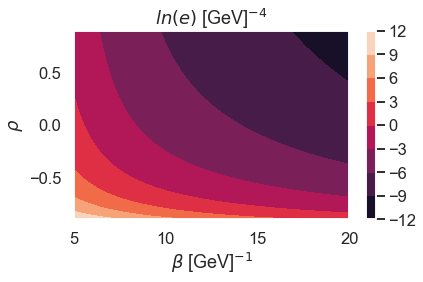

In [8]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
plt.contourf(xx, yy, np.log(eps_grid.T) )
plt.xlabel(r"$\beta$ [GeV]$^{-1}$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(e)$ [GeV]$^{-4}$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

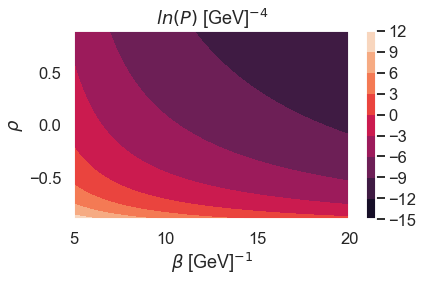

In [9]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
#fig, axes = plt.subplots(1, 1, figsize=(6,4))
plt.contourf(xx, yy, np.log(P_grid.T) )
plt.xlabel(r"$\beta$ [GeV]$^{-1}$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(P)$ [GeV]$^{-4}$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

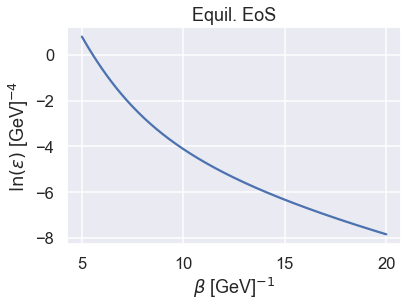

In [10]:
plt.plot(beta_grid, np.log(eq_eps_grid) )
plt.xlabel(r'$\beta$ [GeV]$^{-1}$')
plt.ylabel(r'$\ln(\epsilon)$ [GeV]$^{-4}$')
plt.title(r'Equil. EoS')
plt.show()

### Now we will create interpolations of the grid. 
This will allow us to invert the relations
$$\epsilon = \epsilon(\beta, \rho)$$
$$P = P(\beta, \rho)$$

into 

$$\beta = \beta(\epsilon, P)$$
$$\rho = \rho(\epsilon, P).$$

Once we have the interpolations $\epsilon = \epsilon(\beta, \rho)$ and $P = P(\beta, \rho)$, these can be inverted simultaneously by a two-dimensional root-finding routine.
The Andersen method in the `SciPy` implementation has done fairly well for our tests.

In a real phenomenological setting, each cell on the particlization surface may have a different isotropic pressure, and perhaps a different energy density. In this case, the interpolations can be loaded and reused together with the root finding method to find the Lagrange multipliers $\beta$ and $\rho$ for each cell.

In [11]:
#creating interpolations of the energy density e(beta, lambda) 
#and total pressure P(beta, lambda)
ln_eps_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(eps_grid) )
ln_P_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(P_grid) )

ln_eq_eps_interp = interpolate.interp1d(np.log(eq_eps_grid), beta_grid )
ln_eq_eps_given_beta_interp = interpolate.interp1d(beta_grid, np.log(eq_eps_grid) )

ln_eq_p_interp = interpolate.interp1d(beta_grid, np.log(eq_p_grid) )
#ln_eq_beta_Pi_interp = interpolate.interp1d(beta_grid, np.log(eq_beta_Pi_grid) )

#careful beta_Pi < 0
ln_beta_Pi_interp = interpolate.interp1d(beta_Pi_df['beta[GeV^-1]'], np.log(beta_Pi_df['beta_Pi[GeV/fm^3]']) )
F_interp = interpolate.interp1d(F_df['beta[GeV^-1]'],  F_df['F[GeV]'] )

### Testing the root-finding method and plotting the distribution

In [29]:
##FOR TESTING ROOT SOLVING
#true values of beta and rho
#beta_true = 6.
#rho_true = 0.5
#the values of energy density and total pressure are given
#ln_e0 = ln_eps_interp(beta_true, rho_true).flatten()[0] 
#ln_P0 = ln_P_interp(beta_true, rho_true).flatten()[0] 
##FOR TESTING ROOT SOLVING

##FOR PLOTTING 
T_sw = 0.15 #typical switching temperature in GeV
beta_sw = 1./ T_sw

ln_e0 = ln_eq_eps_given_beta_interp(beta_sw) 

p_sw = np.exp( ln_eq_p_interp(beta_sw) )
bulk_Pi_sw = -1.* p_sw / 2.
P0_sw = p_sw + bulk_Pi_sw
ln_P0 = np.log(P0_sw)
##FOR PLOTTING 

beta_Pi0 = np.exp(ln_beta_Pi_interp(beta_sw))
F0 = F_interp(beta_sw)

print("ln_e0 = " + str(ln_e0) + ", ln_P0 = " + str(ln_P0))

ln_e0 = -1.4116070234226454, ln_P0 = -3.857685550169348


In [30]:
def root_solve_beta_rho(ln_e0, ln_p0, guess, tol=1e-7, maxiter = int(1e5)):
    """Find the solution (beta, rho) which matches both the given
    energy density and total isotr. pressure"""
    def my_fun(x):
        """input is vector with x[0] = beta, x[1] = rho"""
        ln_eps_func = ln_eps_interp(x[0], x[1]).flatten()[0] 
        ln_P_func = ln_P_interp(x[0], x[1]).flatten()[0] 
        return [ln_eps_func - ln_e0, ln_P_func - ln_P0]
    
    solution = optimize.root(my_fun, guess, method='anderson', tol=tol, options={'maxiter':maxiter})
    beta_soln = solution.x[0]
    rho_soln = solution.x[1]
    return beta_soln, rho_soln, solution

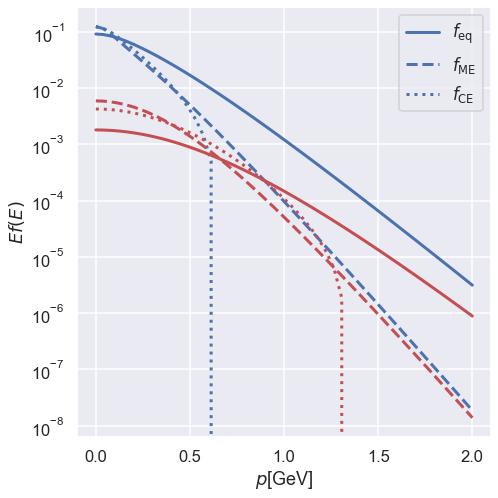

In [31]:
beta_soln, rho_soln, info = root_solve_beta_rho(ln_e0, ln_P0, [7.0, 0.]) 

#now plot these functions
pid_plot = [211, 2212]
pid_color = {211: 'b', 321:'g', 2212: 'r'}
fig, axes = plt.subplots(1, 1, figsize=(7,7))
plt.semilogy()

p_grid = np.linspace(0., 2., 50)

for ipid, pid in enumerate(pid_plot):
    m  = species_dict[pid]['mass']
    sign  = species_dict[pid]['sign']
    degen = species_dict[pid]['degen']
     
    if ipid == 0:
        label_ME = r'$f_{\rm ME}$'
        label_eq = r'$f_{\rm eq}$'
        label_CE = r'$f_{\rm CE}$'
    else:
        label_ME = label_eq = label_CE = None
    
    f_ME_vals = [np.sqrt(p*p + m*m)*f_dist(np.sqrt(p*p + m*m), 
                    beta_soln, rho_soln, m, sign) for p in p_grid]
    f_eq_vals = [np.sqrt(p*p + m*m)*f_eq(np.sqrt(p*p + m*m), beta_sw, sign) for p in p_grid]
    f_lin_CE_vals = [np.sqrt(p*p + m*m)*f_CE_lin(np.sqrt(p*p + m*m), 
                    beta_sw, bulk_Pi_sw, beta_Pi0, F0, m, sign) for p in p_grid] 
    
    plt.plot(p_grid, f_eq_vals, lw=3, label=label_eq, ls='-', color=pid_color[pid])
    plt.plot(p_grid, f_ME_vals, lw=3, label=label_ME, ls='--', color=pid_color[pid])
    plt.plot(p_grid, f_lin_CE_vals, lw=3, label=label_CE, 
             ls=':', color=pid_color[pid])

plt.xlabel(r'$p$[GeV]')
plt.ylabel(r'$E f(E)$')
plt.legend()
plt.tight_layout(True)
plt.savefig('plots/spectra.png', dpi=400)
plt.show()

In [16]:
for ipid, pid in enumerate(pid_plot):
    m  = species_dict[pid]['mass']
    sign  = species_dict[pid]['sign']
    degen = species_dict[pid]['degen']
    
    n_eq0 = n(beta_sw, 0., m, sign)
    n_ME0 = n(beta_soln, rho_soln, m, sign)
    n_CE0 = n_CE(beta_sw, bulk_Pi_sw, beta_Pi0, F0, m, sign)
    
    print("pid = " + str(pid))
    print("n_eq = " + str(n_eq0))
    print("n_CE = " + str(n_CE0))
    print("n_ME = " + str(n_ME0))

pid = 211
n_eq = 0.041008953005075455
n_CE = 0.014380421489477158
n_ME = 0.017330871894955635
pid = 2212
n_eq = 0.001110656070522964
n_CE = 0.0014976168749853969
n_ME = 0.0012781985569745302


In [45]:
#let's compute the particle densities as a function of bulk pressure
first_guess = [7.0, 0.]
guess = first_guess

n_CE_ratio = {}
n_ME_ratio = {}


R_Pi_grid = np.linspace(0., 0.5, 50)

for ipid, pid in enumerate(pid_plot):
    m  = species_dict[pid]['mass']
    sign  = species_dict[pid]['sign']
    degen = species_dict[pid]['degen']
    
    n_eq_arr = []
    n_CE_arr = []
    n_ME_arr = []
    for R_Pi_inv in R_Pi_grid:
        bulk_Pi_sw = -R_Pi_inv * p_sw 
        P0_sw = p_sw + bulk_Pi_sw
        ln_P0 = np.log(P0_sw)
    
        beta_soln, rho_soln, info = root_solve_beta_rho(ln_e0, ln_P0, guess)
        #update guess for next step
        guess = [beta_soln, rho_soln]
        
        n_eq0 = n(beta_sw, 0., m, sign)
        n_ME_arr.append( n(beta_soln, rho_soln, m, sign) / n_eq0 )
        n_CE_arr.append( n_CE(beta_sw, bulk_Pi_sw, beta_Pi0, F0, m, sign) / n_eq0 )
        
    n_CE_ratio[pid] = n_CE_arr
    n_ME_ratio[pid] = n_ME_arr
    

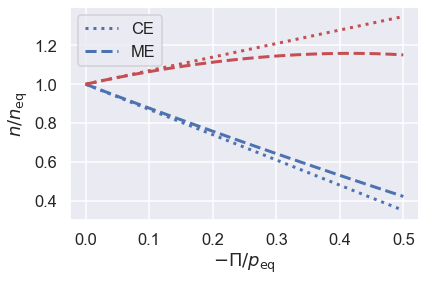

In [67]:
for ipid, pid in enumerate(pid_plot):
    if ipid == 0:
        label_CE = 'CE'
        label_ME = 'ME'
    else:
        label_CE = label_ME = None
    plt.plot(R_Pi_grid, n_CE_ratio[pid], color=pid_color[pid], ls=':', 
             lw=3, label=label_CE)
    plt.plot(R_Pi_grid, n_ME_ratio[pid], color=pid_color[pid], ls='--', 
             lw=3, label=label_ME)

plt.ylabel(r'$n / n_{\rm eq}$')
plt.xlabel(r'$-\Pi / p_{\rm eq}$')
plt.legend()
plt.tight_layout(True)
plt.savefig('plots/densities.png', dpi=400)
plt.show()